In [1]:
import os
import sys
# Allow this notebook to import local libraries 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [25]:
from topic_modelling.preprocessor_all import load_data,get_n_grams
from topic_modelling.pipelines import basic_pipeline, spacy_pipeline, analytics_pipeline
from topic_modelling.preprocessor_all import load_data
from topic_modelling.models import BasicModel

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import warnings

from typing import List,Tuple
warnings.filterwarnings('ignore')


In [3]:
# Increase the columns in pandas so we can clearly see the tweet body
pd.options.display.max_colwidth=150

In [4]:
df = load_data()

Func:load_data took: 0.50 seconds


# Table of contents
* [1. Data Examination](#1)
    * [1.1 Check Nan values](#1.1)
    * [1.2 Check the values of user location](#1.2)
    * [1.3 What is the time-period of those tweets](#1.3)
        * [1.3.1 Min and Max](#1.3.1)
        * [1.3.2 Check if we have any Twitcident](#1.3.2)
        * [1.3.3 Assamption on the frequency of tweets per time](#1.3.3)
* [2. Date-preprocessing](#2)
    * [2.1 Popular n_grams](#2.1)
    * [2.2 Popular Hashtags](#2.2)
    * [2.3 Different Languages](#2.3)
        * [2.3.1 Non en Languages  distribution](#2.3.1)
        * [2.3.2 What other languages are talking about?](#2.3.2)
    



# 1. Data Examination <a class="anchor" id="1"></a>

### 1.1 Check Nan values  <a class="anchor" id="1.1"></a>
* The most consistent fields are the tweet characteristics such as the text, the source and it's statistics such as likes and retweets
* The hashtags are present in the raw text but have been cleaned and stored in a new column
* <b>UserDescription</b> Seems to be reletavily consistent, so we might use this input later one

In [5]:
df.shape

(42368, 30)

In [6]:
df.isna().sum()

TweetPostedTime                  0
TweetID                          0
TweetBody                        0
TweetRetweetFlag                 0
TweetSource                      0
TweetInReplyToStatusID       42267
TweetInReplyToUserID         42179
TweetInReplyToScreenName     42179
TweetRetweetCount                0
TweetFavoritesCount              0
TweetHashtags                  100
TweetPlaceID                 41368
TweetPlaceName               41368
TweetPlaceFullName           41368
TweetCountry                 41369
TweetPlaceBoundingBox        41368
TweetPlaceAttributes         42368
TweetPlaceContainedWithin    42368
UserID                           0
UserLocation                 16026
UserDescription               4364
UserLink                     25769
UserExpandedLink             25806
UserFollowersCount               0
UserFriendsCount                 0
UserListedCount                  0
UserSignupDate                   0
UserTweetCount                   0
tweet.place         

### 1.2 Check the values of user location <a class="anchor" id="1.2"></a>
It seems like those values are not consistent. We have <b>everywhere</b> and <b>global</b> which seems to be the same. Also we have countries and cities in those values. For example <b>London</b> belongs to <b>United Kingdom</b> but they are presented as 2 different values. In addition we have <b>Los Angeles, CA</b> and <b>Los Angeles</b>

Never than less, most of our tweets seems to come from the <b> USA </b>

In [7]:
df.UserLocation.value_counts().head(20)

United States         1226
Japan                  372
united states          371
India                  223
Everywhere             213
Global                 207
South Africa           193
United Kingdom         189
London                 170
The Globe              166
London, England        147
Worldwide              142
Los Angeles, CA        134
Chicago                133
Toronto, Ontario       131
Los Angeles            128
Madison                120
Murrells Inlet, SC     119
Chicago, IL            118
New York, NY           117
Name: UserLocation, dtype: int64

<AxesSubplot:>

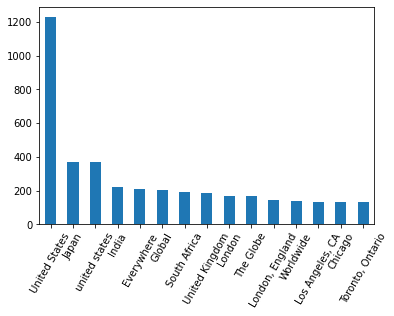

In [8]:
df.UserLocation.value_counts().head(15).plot(kind='bar',rot=60)

### 1.3 What is the time-period of those tweets <a class="anchor" id="1.3"></a>

In [9]:
df.TweetPostedTime.dtype

dtype('O')

In [10]:
# Convert this column from Object to date time
df.TweetPostedTime = df.TweetPostedTime.apply(pd.to_datetime)

In [11]:
df.TweetPostedTime.dtype

datetime64[ns, UTC]

In [12]:
df.TweetPostedTime.describe()

count                         42368
unique                        19842
top       2016-12-20 08:17:03+00:00
freq                            113
first     2016-12-20 00:25:12+00:00
last      2016-12-20 10:57:00+00:00
Name: TweetPostedTime, dtype: object

### 1.3.1 Min and Max <a class="anchor" id="1.3.1"></a>
* All of our tweets are collected from a single date. 
* The time periods are between 00:25 to 10:57 UTC time on the 20-12-2016

In [13]:
df.TweetPostedTime.min()

Timestamp('2016-12-20 00:25:12+0000', tz='UTC')

In [14]:
df.TweetPostedTime.max()

Timestamp('2016-12-20 10:57:00+0000', tz='UTC')

### 1.3.2 Check if we have any Twitcident <a class="anchor" id="1.3.2"></a>
Let's plot the frequency of the tweets per jour to check if there was anything trending

<AxesSubplot:xlabel='TweetPostedTime'>

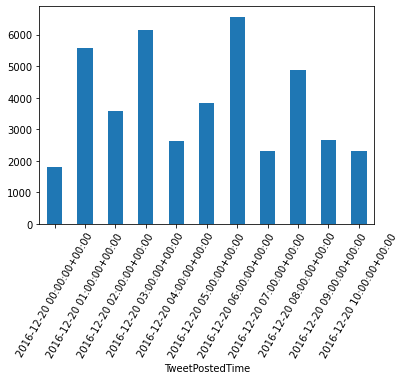

In [15]:
df_time = df.copy()
# Hourly
df_time.resample('H', on='TweetPostedTime').TweetPostedTime.count().plot(kind='bar',rot=60)

<AxesSubplot:xlabel='TweetPostedTime'>

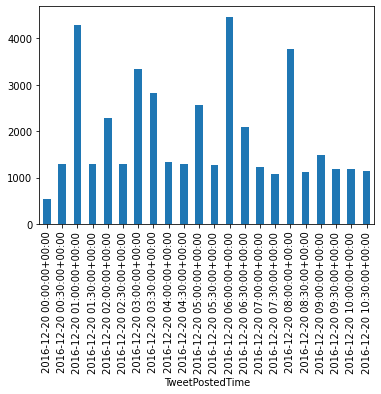

In [16]:
df_time.resample('30min', on='TweetPostedTime').TweetPostedTime.count().plot(kind='bar',rot=90)


### 1.3.3 Assamption on the frequency of tweets per time <a class="anchor" id="1.3.3"></a>
Using the hourly plot we can't really tell if there are solid trends. Howver when we plot the data in intervals of 30 minutes, we can see some spikes but they don't deviate much. 

Here it will be good if we could examine the <b> UserLocation </b> per time iterval to make sure that actually there is a trend

In [17]:
user_loc_per_hour = df_time.resample('H', on='TweetPostedTime').UserLocation.value_counts()

In [18]:
df_time.groupby(df_time.TweetPostedTime.dt.hour).UserLocation.value_counts()

TweetPostedTime  UserLocation             
0                Manchester, England          108
                 Global                        43
                 United States                 18
                 USA                           15
                 Everywhere                    14
                                             ... 
10               千葉県柏市柏3-8-17 グランモール千代田203      1
                 大阪府 大阪市 中央区                    1
                 日本                             1
                 札幌                             1
                 福岡県                            1
Name: UserLocation, Length: 10859, dtype: int64

In [ ]:
# Check the the countries that tweeted the most tweets in the hours between 0-10
hour_of_day = 0
df_time.groupby(df_time.TweetPostedTime.dt.hour).UserLocation.value_counts().loc[lambda x : x>20][hour_of_day].plot(kind='bar')

In [20]:
df[['TweetFavoritesCount','TweetRetweetCount']].describe()

TweetFavoritesCount  TweetRetweetCount
count         42368.000000       42368.000000
mean              0.805561        1081.095402
std              37.214059        1432.473561
min               0.000000           0.000000
25%               0.000000           0.000000
50%               0.000000          14.000000
75%               0.000000        3069.000000
max            2813.000000        4056.000000

# 2. Data-preprocessing <a class="anchor" id="2"></a>
You can find the code of the analytics_pipeline in the Topic Modelling module of the project directory
I created multiple data pipelines to be used in different models and processes

The <b>analytics_pipeline</b> consists of the following methods:
* <b>lang_detector_spacy</b>: assgin a language tag to each document and it's probability
* <b>demoji_preprocessor</b>: remove all emojis
* <b>tweet_preprocessor</b>: Remove urls, mentions, reserved words(e.g. RT)
* <b>spacy_preprocessor</b>: Remove stop words, get the lemma of the word and get only alphabetic characters and lower them
* <b>predefined_denoiser</b>: Remove words that belong to a pre-defined list such as [amp, http, https...]
*  <b>drop_empty</b>: Remove rows that have empty body after preprocessing
*  <b>tokenizer_transformer</b>: tokenize the text
*  <b>ngrammer_2_3</b>: create n-grams by joining words from 1-3 words based on their frequencies

### Should we remove the hashtags?
Some hashtags just don't make any sense. They might be some word abbreviations. On the other hand, those could show some trends. In addtion some hashtags are combined within the text to provide an opinion about something. Like the following example:

    * I went to #Paris and the #view was amazing
    
So if we remove them, we might loose some n-gram counts and sometimes we mightloose the topic from the sentence alltogether.
Maybe it's best to just clean them by removing the # symbol.
Since we already have another column in our DF with the cleaned hashtags, we could remove them from the sentence and then append them on the end of the string. By doing so, we could loose the order, hence some n-grams won't get counted. 

### Hashtags edge cases
* #RT: We removed the RESERVED words in a previous step but when they appear as hashtags they stay in the text


In [21]:
df = analytics_pipeline.apply(df, column='cleanBody')

Func:reset_index took: 0.00 seconds
:: Detecting language using Spacy -> this might take 1-5 minutes....


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:lang_detector_spacy took: 416.00 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:demoji_preprocessor took: 19.88 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:tweet_preprocessor took: 1.19 seconds
:: Spacy preprocessor -> cleaning, this might take 1-2 minutes....


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:spacy_preprocessor took: 55.56 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:predefined_denoiser took: 0.09 seconds
Func:drop_empty took: 0.02 seconds
Func:reset_index took: 0.01 seconds


Pandas Apply:   0%|          | 0/42360 [00:00<?, ?it/s]

Func:tokenizer_transformer took: 0.45 seconds


Pandas Apply:   0%|          | 0/42360 [00:00<?, ?it/s]

Func:ngrammer_2_3 took: 0.58 seconds


## 2.1 Popular n_grams <a class="anchor" id="2.1"></a>
From the bar plot bellow we can identify some trends:

###  Popular Destinations:
* USA / San Dieco
* Israel/Jerusalim
* Italy/Rome, Vatican
* Japan

###  Popular Interests:
Travelers were intrested in:
* Photography
* Nature
* Adventure
* Breakfast in Bed

###  Apartment Types:
Travelers were intrested in:
* Chalet
* Condos
* Camping sites
* Owl house
* Modern Houses
* Light houses

In [26]:
n_grams = Counter(list(chain.from_iterable(df.cleanBody)))

df_tmp = pd.DataFrame(columns = ['grams', 'counts'])
df_tmp['grams'], df_tmp['counts']= zip(*n_grams.most_common(50))

fig = px.bar(df_tmp.sort_values(by='counts'), y='counts', x='grams', title=f'Popular keywords')
fig.show()

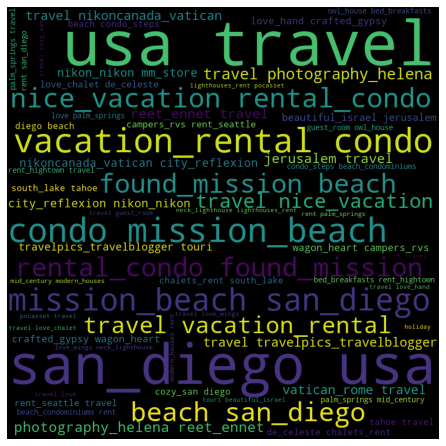

In [27]:
comment_words = " ".join(list(chain.from_iterable(df.cleanBody)))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
plt.title = 'Word Cloud'
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
    

## 2.2 Popular Hashtags<a class="anchor" id="2.2"></a>
From the bar plot bellow we can identify some trends:

###  Popular Destinations:
* Israel/Jerusalim
* Italy/Rome, Vatican
* Japan

###  Popular Destinations:
Travelers were intrested in:
* Photography
* Nature
* Adventure


In [28]:
hashtags = df.TweetHashtags.tolist()
sentence = ''
for row in hashtags:
    sentence += str(row)

hashtags = sentence.lower().replace(',',' ').split()
counts = Counter(hashtags)

top_20_hashtags = counts.most_common(20)

In [29]:
df_tmp = pd.DataFrame(columns = ['grams', 'counts'])
df_tmp['grams'], df_tmp['counts']= zip(*top_20_hashtags)

fig = px.bar(df_tmp.sort_values(by='counts'), y='counts', x='grams', title=f'Popular HashTags')
fig.show()

## 2.3 Different Languages <a class="anchor" id="2.3"></a>
Unfortunately, the language classifier has some False positives. So a lot of times english tweets will be labaled as a different language. 

Below I repeated the above process using just tweets labeled in the following languages:
* it
* ro
* fr
* es
* id # Indonisian
* ca # Catalan

A lot of stop words and english words will appear in those graphs since the classifier is not good enough. Also a lot of Asian tweets are exluded since the Spacy Analyzer removed a lot of them because it conider those characters as not alpabetical. 


In [36]:
langs = df.groupby('lang').size().reset_index(name='counts')
langs.head()

lang  counts
0   af      35
1   ar       3
2   bg      11
3   ca     217
4   cs       8

In [37]:
fig = px.bar(langs.sort_values(by='counts'), y='counts', x='lang', title='Tweet language Distribution')
fig.show()

### 2.2.1 Non en Languages  distribution <a class="anchor" id="2.2.1"></a>


In [38]:
langs_non_en = langs.loc[(langs['lang']!='en') & (langs['counts']>50)]
fig = px.pie(langs_non_en, values='counts', names='lang', title='Tweet language Distripution for Non-english')
fig.show()

### Tweets classified as non English

In [39]:
df[['TweetBody','cleanBody','lang', 'lang_prob']].loc[df.lang =='es'].head(20)

TweetBody  \
18                            ¿Me ayudarías a ganar la aventura de mi vida? https://t.co/ZwIeUgG8R0 #visitpanama #panamabestinfluencer #travel #VR   
126                                                   The latest Las Delicias del Día! https://t.co/HLmLzhCxIi Thanks to @vichycatalan #travel #lp   
241                        Please RT #viajes #viajar #travel La Primera maratón femenina del Mundo https://t.co/9rLklcwDn6 https://t.co/OdQxJOfOBs   
381                             #madrid #españa #estacion #atocha #renfe #metro #ave #travel #traveling #TFLers #vacation… https://t.co/Zdfaa82Ch1   
456                                                                             The latest Canal Viajeros! https://t.co/Yv3VPIsnu3 #travel #viajes   
523                  reserva ahora las tarifas mas baratas con condor https://t.co/NV4kwdXqHC IneedHelp x #travel #ENGvPOR https://t.co/IiuQGxthdl   
525           reserva ahora las tarifas mas baratas con condor https://t.co/NV4kwdXqHC Green Liberty xvcm #travel #ENGvPOR https://t.co/z1QOQsnRfP   
829   RT @bermaxo09: Vista del Faro de  #Maspalomas desde #SanFernandodeMaspalomas  #GranCanaria #photos #Fotos #turismo #travel #holidays #Navid…   
831                                   Please RT #viajes #viajar #travel &amp;quot;The Tube&amp;quot;: el metro londinense. https://t.co/IsUHnd5aeb   
835   RT @bermaxo09: Desde las #Dunas de  #Maspalomas mirando "pa" la Cumbre  #GranCanaria #arena #playa #travel  #photos #quesuerteviviraqui #va…   
836       Please RT #viajes #viajar #travel Montan el primer complejo deportivo de surf en Ibiza https://t.co/RqAnjLlSJJ https://t.co/6HdefXZ4Kp …   
839   Please RT #viajes #viajar #travel Qué se puede hacer en Khantati https://t.co/2yuoD97NY3 https://t.co/LCtjtMNHe0\n\nPlease RT #viajes #viaj…   
870                                                                                                       https://t.co/VdbgBc4VYL\n #travel #guide   
877   RT @andaluciaparais: Almodóvar del Río y su majestuoso castillo.\n#Córdoba #Viajes #Travel \nhttps://t.co/PhqBXnOJri https://t.co/gMVT96mGwY   
941                                                  El día que cruzamos la frontera: Nepal - #travel #lachicadeloschistes https://t.co/Lcg5o8PWQ0   
953   RT @HolaNomada: Cómo mantenerse viajando vía @marcandoelpolo https://t.co/5vPxTDBC5V #NómadaDigital #Viajar #Travel #TravelBlog #Felizjueves   
974          RT @blogsturismoram: Please RT #viajes #viajar #travel MOSCÚ Y SAN PETERSBURGO 7 días https://t.co/PLuKzfgNCF https://t.co/aXmvsMlNNx   
1156                  RT @1pocodesur: Guía para viajar con perros vía @PorlasrutasdelM https://t.co/R2ilWEOn6y #Viajar #Perros #Mochileros #Travel   
1189  RT @estautopia: 🇫🇷 #Travel / NUEVA ENTRADA! Bon jour #LaFrance 😊 Primera parte del viaje a París ya disponible en el blog 🖥 https://t.co/6m…   
1204          Comer mal en #Navidad (y otros meses) https://t.co/aXMEqNaRUf vía @wordpressdotcom #mexico #vacaciones #viajes #travel #diet #curves   

                                                                                                                             cleanBody  \
18                                        [ayudarías, ganar, la, aventura, de, mi, vida, visitpanama_panamabestinfluencer, travel, vr]   
126                                                                              [latest, las, delicias, del, día, thanks, travel, lp]   
241                                                            [rt_viajes, viajar, travel, la, primera, maratón, femenina, del, mundo]   
381                                         [madrid, españa, estacion, atocha, renfe, metro, ave, travel, traveling, tflers, vacation]   
456                                                                                          [latest, canal, viajeros, travel, viajes]   
523                                             [reserva_ahora, las_tarifas, mas, baratas, con, condor, ineedhelp, x, travel, engvpor]   
525                 

### 2.2.2 What other languages are talking about? <a class="anchor" id="2.2.2"></a>


In [42]:
en_tweets = df.loc[df['lang']=='en']
it_tweets = df.loc[df['lang']=='it']
ro_tweets = df.loc[df['lang']=='ro']
fr_tweets = df.loc[df['lang']=='fr']
es_tweets = df.loc[df['lang']=='es']
id_tweets = df.loc[df['lang']=='id'] # Indonisian
ca_tweets = df.loc[df['lang']=='ca'] # Catalan

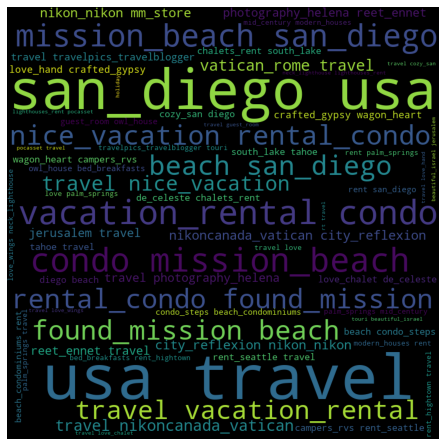

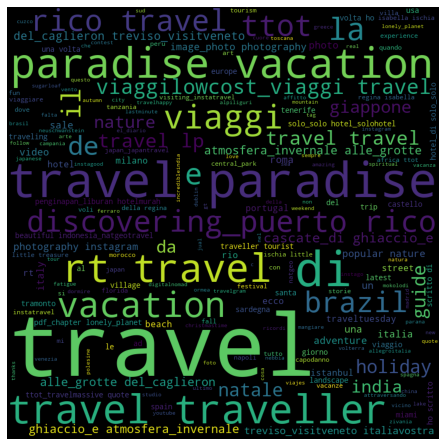

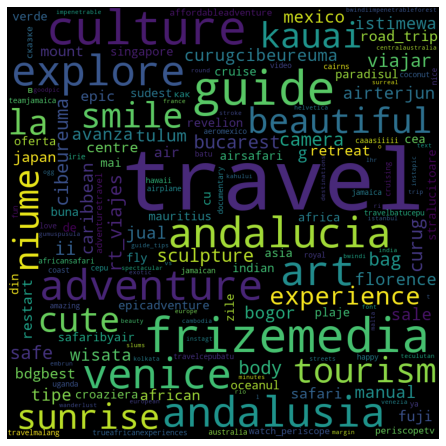

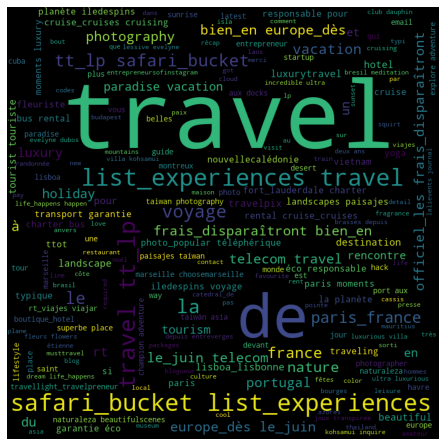

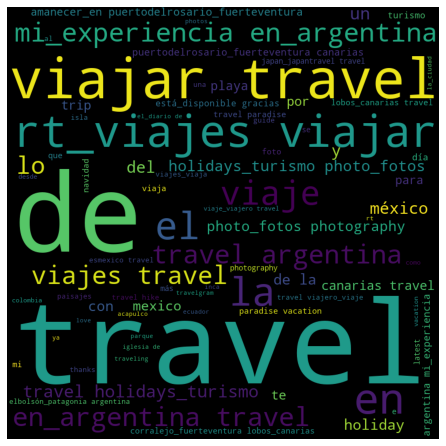

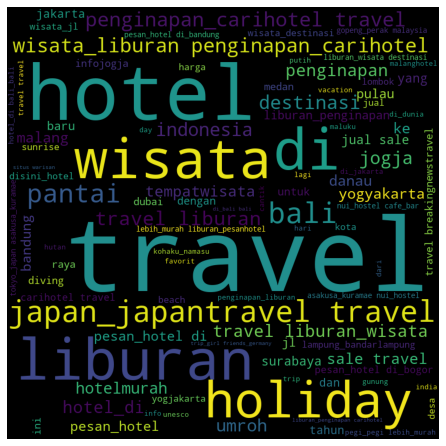

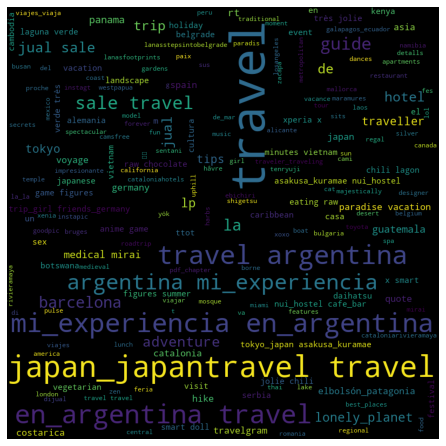

In [43]:
for df_tmp in [en_tweets ,it_tweets,ro_tweets,fr_tweets,es_tweets,id_tweets,ca_tweets]:
    lang_name = df_tmp.lang.iloc[0]
    
    n_grams = Counter(list(chain.from_iterable(df_tmp.cleanBody)))

    comment_words = " ".join(list(chain.from_iterable(df_tmp.cleanBody)))
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black',
                    min_font_size = 10).generate(comment_words)


    df_tmp = pd.DataFrame(columns = ['grams', 'counts'])
    df_tmp['grams'], df_tmp['counts']= zip(*n_grams.most_common(50))

    fig = px.bar(df_tmp.sort_values(by='counts'), y='counts', x='grams', title=f'Popular keywords for {lang_name}')
    fig.show()
    
        # plot the WordCloud image
    plt.title = 'Word Cloud'
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()
    